In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import json
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model, Sequential

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


--------------------
### Build ConvAE 

In [3]:
### model params
lr=0.0001
num_epoch=16
batch_size=32
num_test_images=10
save_every = 5

In [4]:
def model_fn(shape=(28,28,1)) :
    x = inp = Input(shape=shape, name='encoding_input')
    
    # layer 1
    x = Conv2D(filters=16, kernel_size=3, padding='same')(x)
    x = ReLU()(x)
    #x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    
    # layer 2
    x = Conv2D(filters=10, kernel_size=3, padding='same')(x)
    x = ReLU()(x)
    #x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
        
    # layer 3
    #x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    #x = LeakyReLU()(x)
    #x = MaxPooling2D((2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
             
    # build model for encoder
    encoder = Model(inp, x, name='encoder')
             
    x = inp = Input(x.shape[1:], name="decoder_input")
    # layer 4
    #x = Conv2DTranspose(filters=32, kernel_size=3,strides=(2,2),padding='same')(x)
    #x = LeakyReLU()(x)
    #x = BatchNormalization()(x)
    
    # layer 5
    x = Conv2DTranspose(filters=10, kernel_size=3,strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
             
    # layer 4
    x = Conv2DTranspose(filters=16, kernel_size=3,strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    
    # layer 5
    x = Conv2D(filters=1, kernel_size=3, padding='same')(x)
    decoder = Model(inp, x, name='decoder')
             
    return encoder, decoder

--------------------
- L2 loss

In [5]:
def loss_fn(output_layer, input_layer):
    return tf.reduce_mean(tf.square(output_layer-input_layer))

--------------------
- L2 + Scale invariant  
$$
Loss = \sum_{i}{\min_{\theta} || x_i - R_{\theta} \hat{x}_i ||_{2}^{2}} + \lambda \cdot \sum_{i}{\max_{\theta}|| z_{i}(x_i) - z_{i}(R_{\theta}x_i)||_{2}^{2}}
$$

Note: Rotate API should be "Radian" based angles. SHOULD convert degree to angle with multiipying  $$\times math.pi / 180$$

In [5]:
def loss_dev_fn(output_layer,
                input_layer,
                encoded_imgs,
                encoder,
                batch_size=32, dangle=2, c_lambda=1
               ):

    def rotate_operation(imgs, angle=1):
        """angle: Radian.
            angle = degree * math.pi/180
        """
        rimgs = tf.contrib.image.rotate(
                imgs,
                tf.constant(angle ,dtype=tf.float32),
                interpolation='NEAREST',
                name=None
        )
        return rimgs

    # loss lists
    loss_reconst = [] # first term
    loss_hidden  = [] # seconds term

    # angle list has Radian-based angle from 1 t0 360 degrees
    angle_list = [i*math.pi/180 for i in range(1,360,dangle)]
    for angle in angle_list:
        rimgs = rotate_operation(output_layer,angle=angle) # R_theta(x_hat)
        rencoded_imgs = rotate_operation(encoded_imgs,angle=angle) # Z(R(x))

        # loss
        loss_reconst.append(tf.reduce_mean(tf.square(input_layer - rimgs)) )
        loss_hidden.append(tf.reduce_mean(tf.square(encoded_imgs - rencoded_imgs)))

    # Get min-max
    reconst = tf.reduce_min(tf.stack(loss_reconst))
    hidden  = tf.reduce_max(tf.stack(loss_reconst))

    return reconst + tf.multiply(tf.constant(c_lambda ,dtype=tf.float32), hidden)

-------------------------------
Pipeline

In [6]:
def input_fn(data, batch_size=32):
    data1 = data.reshape(-1,28,28,1)
    dataset = tf.data.Dataset.from_tensor_slices((data1))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    #dataset = dataset.repeat().batch(batch_size)
    return dataset

In [7]:
def rotate_fn(images):
    """
    Apply random rotation to data and parse to dataset module
    images: before parse to encoder

    * copy function from classifier.py
    """
    # float point 32
    images = images.astype(np.float32)

    # random rotation
    random_angles = tf.random.uniform(
        shape = (tf.shape(images)[0], ),
        minval = 0*math.pi/180,
        maxval = 359*math.pi/180,
        dtype=tf.float32,
        seed = 0
    )
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        random_angles, tf.cast(tf.shape(images)[1], tf.float32),
            tf.cast(tf.shape(images)[2], tf.float32)
        )
    )

    # convert from tensor to numpy
    sess = tf.Session()
    with sess.as_default():
        rotated_images = rotated_tensor_images.eval()
    return rotated_images

Set up Training; L2 loss

In [8]:
# get model
encoder, decoder = model_fn()

# get dataset and one-shot-iterator
dataset = input_fn(mnist.train.images, batch_size=batch_size)
img= dataset.make_one_shot_iterator().get_next()

# get layer output
encoder_img = encoder(img)
decoder_img = decoder(encoder_img)

# compute loss and train_ops
loss = loss_fn(decoder_img, img)
train_ops = tf.train.AdamOptimizer(lr).minimize(loss)

Set up Training; L2 loss with randomly rotated train data

In [8]:
# get model
encoder, decoder = model_fn()

# get dataset and one-shot-iterator
rtrain_imgs = mnist.train.images.reshape(-1,28,28,1)
rotated_imgs = rotate_fn(rtrain_imgs)
dataset = input_fn(rotated_imgs, batch_size=batch_size)
img= dataset.make_one_shot_iterator().get_next()

# get layer output
encoder_img = encoder(img)
decoder_img = decoder(encoder_img)

# compute loss and train_ops
loss = loss_fn(decoder_img, img)
train_ops = tf.train.AdamOptimizer(lr).minimize(loss)

Check model

In [9]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoding_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        1450      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 10)        0         
__________

Set up Training; L2 + scale invarinat

In [7]:
# get model
encoder, decoder = model_fn()

# get dataset and one-shot-iterator
dataset = input_fn(mnist.train.images, batch_size=batch_size)
img= dataset.make_one_shot_iterator().get_next()

# get layer output
encoder_img = encoder(img)
decoder_img = decoder(encoder_img)

# compute loss and train_ops
loss = loss_dev_fn(decoder_img, img, encoder_img,
                   encoder,
                   batch_size=batch_size, dangle=2, c_lambda=1)
train_ops = tf.train.AdamOptimizer(lr).minimize(loss)

------------
#### Training

- L2 Loss

epoch 0 loss 0.12066596746444702
epoch 1 loss 0.1262245774269104
epoch 2 loss 0.12350712716579437
epoch 3 loss 0.12638318538665771
epoch 4 loss 0.11508753150701523


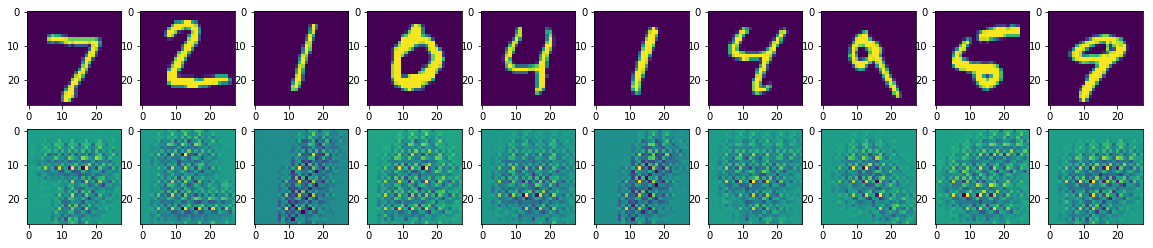

In [71]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for i in range(0,1,1):
        #for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
            train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
            print("epoch {} loss {}".format(epoch,train_loss))   
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))
    plt.show()

- Settings  
lr=0.0001  
num_epoch=5  
batch_size=150  

epoch 0 loss 0.04033612087368965
epoch 1 loss 0.02793402411043644
epoch 2 loss 0.021726729348301888
epoch 3 loss 0.019261585548520088
epoch 4 loss 0.015570100396871567


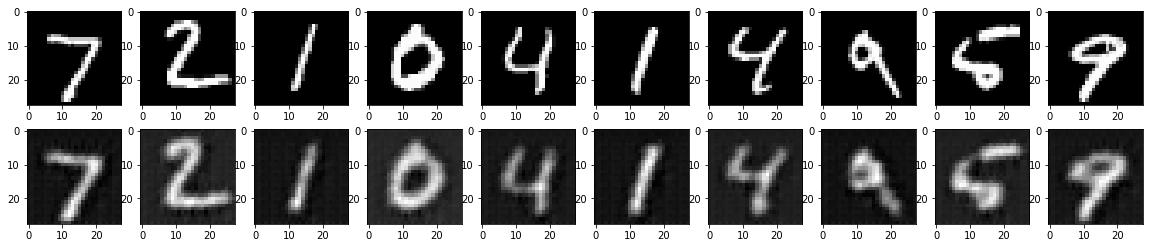

In [12]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
        train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
        print("epoch {} loss {}".format(epoch,train_loss))   
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)), cmap='gist_gray')
        a[1][i].imshow(np.reshape(results[i],(28,28)), cmap='gist_gray')
    plt.show()

- L2 Loss with scale invarinat 

epoch 0 loss 0.13036304712295532
epoch 1 loss 0.12782081961631775
epoch 2 loss 0.12085231393575668
epoch 3 loss 0.12462939321994781
epoch 4 loss 0.12374880164861679


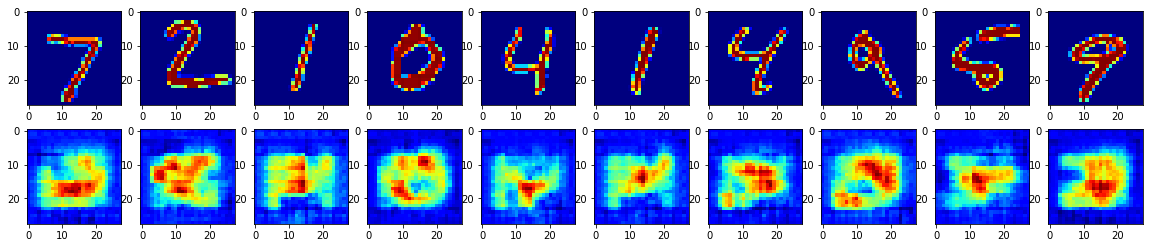

In [8]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
        train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
        print("epoch {} loss {}".format(epoch,train_loss))   
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)), cmap='jet')
        a[1][i].imshow(np.reshape(results[i],(28,28)), cmap='jet')
    plt.show()

#### 08/14 save model and fig for ppt slide
- Original vanila Conv-Autoencoder

In [16]:
basedir='/home/tkurihana/scratch-midway2/clouds/metrics'
figdir=basedir+'/fig'
logdir=basedir+'/log'
modeldir=basedir+'/output_model/original4'

epoch 0 loss 0.013245712965726852
epoch 1 loss 0.008599070832133293
epoch 2 loss 0.006463686004281044
epoch 3 loss 0.005691965576261282
epoch 4 loss 0.005163125693798065
epoch 5 loss 0.004788737744092941


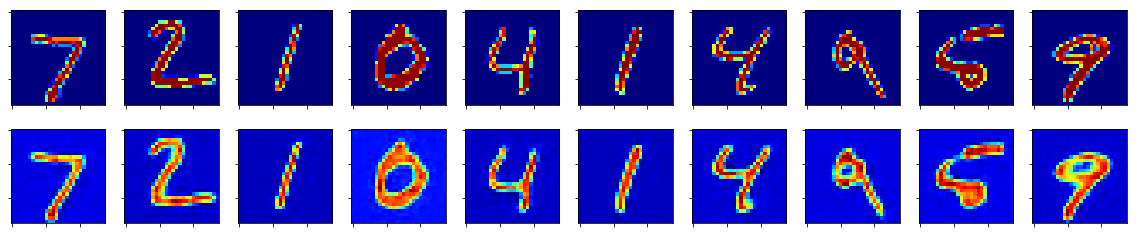

In [12]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

# setup for save model & log
os.makedirs(modeldir, exist_ok=True)

save_models = {"encoder": encoder, "decoder":decoder}
for m in save_models:
    with open(os.path.join(modeldir, m+'.json'), 'w') as f:
        f.write(save_models[m].to_json())

# output name
bname1 = 'nepoch-'+str(num_epoch)+'_lr-'+str(lr)
bname2 = '_nbatch-'+str(batch_size)
figname   = 'fig_original_'+bname1+bname2
ofilename = 'loss_original_'+bname1+bname2+'.txt'

train_loss_list = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
        train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
        print("epoch {} loss {}".format(epoch,train_loss))   
        train_loss_list.append(train_loss)
    
        # save model at every N steps
        if epoch % save_every == 0:
            for m in save_models:
                save_models[m].save_weights(
                    os.path.join(
                        modeldir, "{}-{}.h5".format(m, epoch)
                    )
                )
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)), cmap='jet')
        a[1][i].imshow(np.reshape(results[i],(28,28)), cmap='jet')
        #
        a[0][i].set_xticklabels([])
        a[0][i].set_yticklabels([])
        a[1][i].set_xticklabels([])
        a[1][i].set_yticklabels([])
    plt.savefig(figdir+'/'+figname+'.png')
    
    # loss list save
    with open(os.path.join(logdir, ofilename), 'w') as f:
        for ie in train_loss_list:
            f.write(str(ie)+'\n')

##### 08/19 With rotated train data

epoch 0 loss 0.013974183239042759
epoch 1 loss 0.012488828971982002
epoch 2 loss 0.010781637392938137
epoch 3 loss 0.010008790530264378
epoch 4 loss 0.009222541935741901
epoch 5 loss 0.008743620477616787


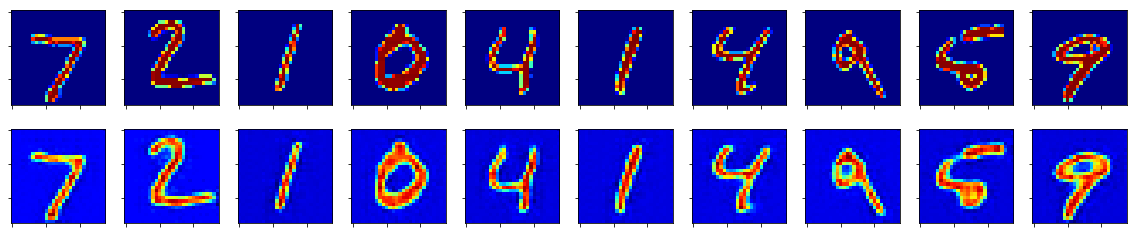

In [11]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

# setup for save model & log
os.makedirs(modeldir, exist_ok=True)

save_models = {"encoder": encoder, "decoder":decoder}
for m in save_models:
    with open(os.path.join(modeldir, m+'.json'), 'w') as f:
        f.write(save_models[m].to_json())

# output name
bname1 = 'nepoch-'+str(num_epoch)+'_lr-'+str(lr)
bname2 = '_nbatch-'+str(batch_size)
figname   = 'fig_original_'+bname1+bname2
ofilename = 'loss_original_'+bname1+bname2+'.txt'

train_loss_list = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
        train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
        print("epoch {} loss {}".format(epoch,train_loss))   
        train_loss_list.append(train_loss)
    
        # save model at every N steps
        if epoch % save_every == 0:
            for m in save_models:
                save_models[m].save_weights(
                    os.path.join(
                        modeldir, "{}-{}.h5".format(m, epoch)
                    )
                )
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)), cmap='jet')
        a[1][i].imshow(np.reshape(results[i],(28,28)), cmap='jet')
        #
        a[0][i].set_xticklabels([])
        a[0][i].set_yticklabels([])
        a[1][i].set_xticklabels([])
        a[1][i].set_yticklabels([])
    plt.savefig(figdir+'/'+figname+'.png')
    
    # loss list save
    with open(os.path.join(logdir, ofilename), 'w') as f:
        for ie in train_loss_list:
            f.write(str(ie)+'\n')

epoch 0 loss 0.01731112413108349
epoch 1 loss 0.012062564492225647
epoch 2 loss 0.009390478022396564
epoch 3 loss 0.00902333203703165
epoch 4 loss 0.00863631907850504
epoch 5 loss 0.008670641109347343
epoch 6 loss 0.008579498156905174
epoch 7 loss 0.008340941742062569
epoch 8 loss 0.008013363927602768
epoch 9 loss 0.00782198179513216
epoch 10 loss 0.00864698551595211
epoch 11 loss 0.00800705049186945
epoch 12 loss 0.007238813675940037
epoch 13 loss 0.00753779336810112
epoch 14 loss 0.007628283929079771
epoch 15 loss 0.006921220570802689


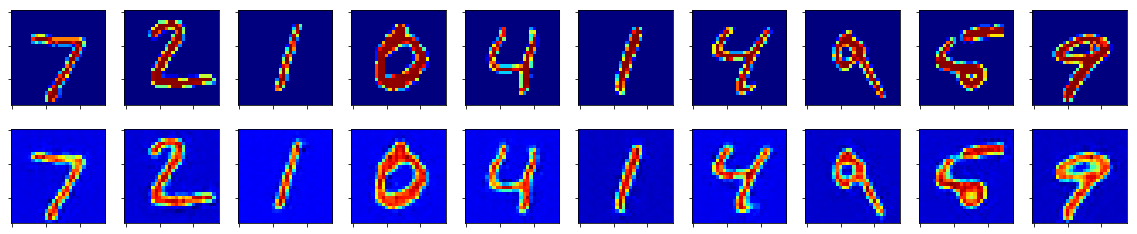

In [17]:
# initialize
init=tf.global_variables_initializer()
X=tf.placeholder(tf.float32,shape=[None,28,28,1])

# setup for save model & log
os.makedirs(modeldir, exist_ok=True)

save_models = {"encoder": encoder, "decoder":decoder}
for m in save_models:
    with open(os.path.join(modeldir, m+'.json'), 'w') as f:
        f.write(save_models[m].to_json())

# output name
bname1 = 'nepoch-'+str(num_epoch)+'_lr-'+str(lr)
bname2 = '_nbatch-'+str(batch_size)
figname   = 'fig_original_'+bname1+bname2
ofilename = 'loss_original_'+bname1+bname2+'.txt'

train_loss_list = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train_ops)
        
        train_loss=loss.eval(feed_dict={X:X_batch.reshape(-1,28,28,1)})
        print("epoch {} loss {}".format(epoch,train_loss))   
        train_loss_list.append(train_loss)
    
        # save model at every N steps
        if epoch % save_every == 0:
            for m in save_models:
                save_models[m].save_weights(
                    os.path.join(
                        modeldir, "{}-{}.h5".format(m, epoch)
                    )
                )
    
    encoded=encoder(
        mnist.test.images[:num_test_images].reshape(-1,28,28,1)
    )
    results = decoder(encoded).eval()
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)), cmap='jet')
        a[1][i].imshow(np.reshape(results[i],(28,28)), cmap='jet')
        #
        a[0][i].set_xticklabels([])
        a[0][i].set_yticklabels([])
        a[1][i].set_xticklabels([])
        a[1][i].set_yticklabels([])
    plt.savefig(figdir+'/'+figname+'.png')
    
    # loss list save
    with open(os.path.join(logdir, ofilename), 'w') as f:
        for ie in train_loss_list:
            f.write(str(ie)+'\n')

-----------------------
## 08/27
### Check debug functions

In [5]:
from train import make_copy_rotate

In [10]:
import itertools

In [11]:
def loss_rotate_fn(imgs,
                   encoder,
                   batch_size=32,
                   copy_size=4,
                   c_lambda=1
                   ):
    shape = (-1,28,28,1)
    loss_rotate_list = []
    for idx in range(int(batch_size/copy_size)):
        _imgs = imgs[copy_size*idx:copy_size*(idx+1)]
        _loss_rotate_list = []
        for (i,j) in itertools.combinations([i for i in range(copy_size)],2):
            ### comment off for debug
            #loss_rotate_list.append(
            #  tf.reduce_mean(tf.square( 
            #          encoder(tf.reshape(_imgs[i],shape)) - encoder(tf.reshape(_imgs[j],shape)) 
            #      )
            #  )
            #)
            #loss_rotate_list.append(tf.reduce_max(loss_rotate_list))
            loss_rotate_list.append(_imgs[i])
            loss_rotate_list.append(_imgs[j])
    #TODO think this operation again
    # tf.reduce mean?
    #loss_rotate = tf.reduce_mean(tf.stack(loss_rotate_list))
    #return tf.multiply(tf.constant(c_lambda ,dtype=tf.float32), loss_rotate)
    return loss_rotate_list

In [4]:
def input_fn(data, batch_size=32, rotation=False, copy_size=4):
    # check batch/copy ratio
    try:
      if batch_size % copy_size == 0:
        print("\n Number of actual original images == {} ".format(int(batch_size/copy_size)))
    except:
      raise ValueError("\n Division of batch size and copy size is not Integer \n")

    data1 = data.reshape(-1,28,28,1)
    if rotation:
      data1 = rotate_fn(data1)
      print(" Apply rondam rotation to training images for AE ")
    dataset = tf.data.Dataset.from_tensor_slices((data1))
    #dataset = dataset.shuffle(1000).repeat().batch(int(batch_size/copy_size))
    dataset = dataset.repeat().batch(int(batch_size/copy_size))
    return dataset

In [7]:
# get dataset and one-shot-iterator
dataset = input_fn(mnist.train.images,
                     batch_size=32,
                     rotation=False,
                     copy_size=4
)
img_beforeCopyRotate = dataset.make_one_shot_iterator().get_next()
# convert imgs to imgs with copy of rotations
img = make_copy_rotate(img_beforeCopyRotate,copy_size=4)


 Number of actual original images == 8 


In [12]:
imgs_list = loss_rotate_fn(img, np.ones((2)))

In [13]:
len(imgs_list)

96

In [18]:
imgs_np_list = []
sess = tf.Session()
with sess.as_default():
    for i in imgs_list:
        imgs_np_list.append(i.eval())

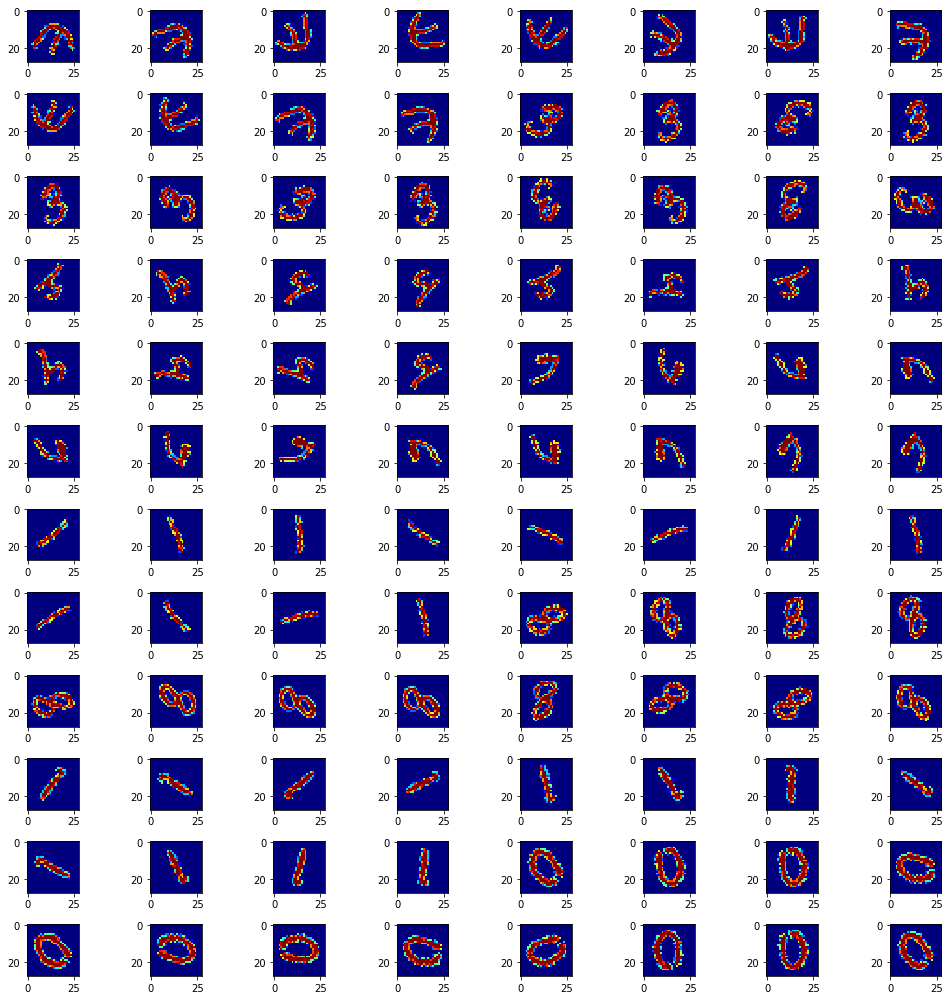

In [24]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
for idx, i in enumerate(imgs_np_list):
    ax = plt.subplot(12,8,idx+1)
    plt.imshow(i.reshape(28,28), cmap='jet')
fig.tight_layout()
plt.show()